<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4_lg%ED%99%94%ED%95%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

## 라이브러리 설치

In [25]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install pykrx

## 패키지 로딩 및 함수 로딩

In [65]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [66]:
def money_sur(stock_name, start, end):

  # 라이브러리를 찾음... 한방에 나옴...
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

## 데이터 로드

In [67]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
df = money_sur('051910',2018, end_date)

In [68]:
df

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
0,2018-01-02,407000,415000,406500,411000,153739,0.014815,188597,23.60,2.18,17417,1.22,5000
1,2018-01-03,404000,413000,404000,409500,103370,-0.003650,188597,23.51,2.17,17417,1.22,5000
2,2018-01-04,410000,412000,395000,395500,215698,-0.034188,188597,22.71,2.10,17417,1.26,5000
3,2018-01-05,396500,405500,395000,405000,154954,0.024020,188597,23.25,2.15,17417,1.23,5000
4,2018-01-08,409000,425000,407000,424500,321484,0.048148,188597,24.37,2.25,17417,1.18,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2021-09-27,763000,770000,757000,770000,234240,0.011827,230440,115.51,3.34,6666,1.30,10000
920,2021-09-28,777000,783000,765000,776000,293276,0.007792,230440,116.41,3.37,6666,1.29,10000
921,2021-09-29,762000,769000,749000,767000,346422,-0.011598,230440,115.06,3.33,6666,1.30,10000
922,2021-09-30,754000,780000,748000,776000,365073,0.011734,230440,116.41,3.37,6666,1.29,10000


## 데이터 전처리

In [69]:
df1 = df.set_index('Date')

In [70]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

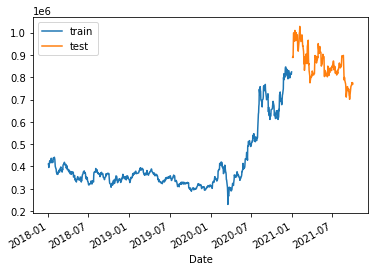

In [71]:
# test --> 21년 이후 , train --> 18~20
split_date = pd.Timestamp('01-01-2021')

train = df1.loc[:split_date, ]
test = df1.loc[split_date:, ]

ax = train['Close'].plot()
test['Close'].plot(ax=ax)
plt.legend(['train', 'test'])

In [72]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.26094003, 0.24067797, 0.28652597, ..., 0.62644488, 0.41350214,
        0.75      ],
       [0.2560778 , 0.23728814, 0.28246753, ..., 0.62644488, 0.41350214,
        0.75      ],
       [0.26580227, 0.23559322, 0.26785714, ..., 0.62644488, 0.43037976,
        0.75      ],
       ...,
       [0.92706645, 0.93389831, 0.93668831, ..., 0.        , 0.00421941,
        0.        ],
       [0.92544571, 0.93898305, 0.93344156, ..., 0.        , 0.00421941,
        0.        ],
       [0.91896272, 0.93389831, 0.93344156, ..., 0.        , 0.        ,
        0.        ]])

In [73]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

In [74]:
scale_cols = list(df1.columns)

train_sc_df = pd.DataFrame(train_sc, columns=[scale_cols], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=[scale_cols], index=test.index)

In [75]:
# 종가로만 예측 시
# train_close = pd.DataFrame(train_sc_df[('Close',)])
# test_close = pd.DataFrame(test_sc_df[('Close',)])

In [76]:
for i in scale_cols:
  for s in range(1, 11):  
    train_sc_df[(i+'shift_{}'.format(s),)] = train_sc_df[(i,)].shift(s)
    test_sc_df[(i+'shift_{}'.format(s),)] = test_sc_df[(i,)].shift(s)

train_sc_df.head(11)
train_sc_df.shape

(738, 132)

In [77]:
test_sc_df.shape

(186, 132)

In [78]:
train_sc_df.columns

MultiIndex([(       'Open',),
            (       'High',),
            (        'Low',),
            (      'Close',),
            (     'Volume',),
            (     'Change',),
            (        'BPS',),
            (        'PER',),
            (        'PBR',),
            (        'EPS',),
            ...
            ( 'DPSshift_1',),
            ( 'DPSshift_2',),
            ( 'DPSshift_3',),
            ( 'DPSshift_4',),
            ( 'DPSshift_5',),
            ( 'DPSshift_6',),
            ( 'DPSshift_7',),
            ( 'DPSshift_8',),
            ( 'DPSshift_9',),
            ('DPSshift_10',)],
           length=132)

In [79]:
train_sc_df.head(11)

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.260940,0.240678,0.286526,0.293831,0.027212,0.532225,0.0,0.059601,0.397887,0.626445,0.413502,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.256078,0.237288,0.282468,0.291396,0.012156,0.481409,0.0,0.059140,0.394366,0.626445,0.413502,0.75,0.260940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.397887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.626445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.265802,0.235593,0.267857,0.268669,0.045732,0.397363,0.0,0.055040,0.369718,0.626445,0.430380,0.75,0.256078,0.260940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237288,0.240678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282468,0.286526,NaN,NaN,NaN,NaN,NaN,NaN,...,0.394366,0.397887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.626445,0.626445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413502,0.413502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.243922,0.224576,0.267857,0.284091,0.027575,0.557560,0.0,0.057808,0.387324,0.626445,0.417722,0.75,0.265802,0.256078,0.260940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.235593,0.237288,0.240678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.267857,0.282468,0.286526,NaN,NaN,NaN,NaN,NaN,...,0.369718,0.394366,0.397887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.626445,0.626445,0.626445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.430380,0.413502,0.413502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.75,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.264182,0.257627,0.287338,0.315747,0.077353,0.623963,0.0,0.063547,0.422535,0.626445,0.396624,0.75,0.243922,0.265802,0.256078,0.260940,NaN,NaN,NaN,NaN,NaN,NaN,0.224576,0.235593,0.237288,0.240678,NaN,NaN,NaN,NaN,NaN,NaN,0.267857,0.267857,0.282468,0.286526,NaN,NaN,NaN,NaN,...,0.387324,0.369718,0.394366,0.397887,NaN,NaN,NaN,NaN,NaN,NaN,0.626445,0.626445,0.626445,0.626445,NaN,NaN,NaN,NaN,NaN,NaN,0.417722,0.430380,0.413502,0.413502,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.75,0.75,0.75,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.294165,0.277119,0.314935,0.317370,0.051667,0.497936,0.0,0.063855,0.426056,0.626445,0.396624,0.75,0.264182,0.243922,0.265802,0.256078,0.260940,NaN,NaN,NaN,NaN,NaN,0.257627,0.224576,0.235593,0.237288,0.240678,NaN,NaN,NaN,NaN,NaN,0.287338,0.267857,0.267857,0.282468,0.286526,NaN,NaN,NaN,...,0.422535,0.387324,0.369718,0.394366,0.397887,NaN,NaN,NaN,NaN,NaN,0.626445,0.626445,0.626445,0.626445,0.626445,NaN,NaN,NaN,NaN,NaN,0.396624,0.417722,0.430380,0.413502,0.413502,NaN,NaN,NaN,NaN,NaN,0.75,0.75,0.75,0.75,0.75,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.294165,0.263559,0.302760,0.302760,0.018988,0.433241,0.0,0.061190,0.408451,0.626445,0.405063,0.75,0.294165,0.264182,0.243922,0.265802,0.256078,0.260940,NaN,NaN,NaN,NaN,0.277119,0.257627,0.224576,0.235593,0.237288,0.240678,NaN,NaN,NaN,NaN,0.314935,0.287338,0.267857,0.267857,0.282468,0

In [80]:
X_train = train_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_train = train_sc_df.dropna()[['Close']]

X_test = test_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = test_sc_df.dropna()[['Close']]

X_train.head()

,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,Lowshift_9,Lowshift_10,Closeshift_1,Closeshift_2,Closeshift_3,Closeshift_4,Closeshift_5,Closeshift_6,Closeshift_7,Closeshift_8,Closeshift_9,Closeshift_10,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.291734,0.279579,0.284441,0.294165,0.294165,0.264182,0.243922,0.265802,0.256078,0.260940,0.285593,0.264407,0.259322,0.263559,0.277119,0.257627,0.224576,0.235593,0.237288,0.240678,0.317370,0.306006,0.301136,0.302760,0.314935,0.287338,0.267857,0.267857,0.282468,0.286526,0.336039,0.318182,0.310877,0.302760,0.317370,0.315747,0.284091,0.268669,0.291396,0.293831,...,0.447183,0.426056,0.415493,0.408451,0.426056,0.422535,0.387324,0.369718,0.394366,0.397887,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.379747,0.392405,0.400844,0.405063,0.396624,0.396624,0.417722,0.430380,0.413502,0.413502,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2018-01-17,0.311183,0.291734,0.279579,0.284441,0.294165,0.294165,0.264182,0.243922,0.265802,0.256078,0.283898,0.285593,0.264407,0.259322,0.263559,0.277119,0.257627,0.224576,0.235593,0.237288,0.323052,0.317370,0.306006,0.301136,0.302760,0.314935,0.287338,0.267857,0.267857,0.282468,0.327110,0.336039,0.318182,0.310877,0.302760,0.317370,0.315747,0.284091,0.268669,0.291396,...,0.436620,0.447183,0.426056,0.415493,0.408451,0.426056,0.422535,0.387324,0.369718,0.394366,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.388186,0.379747,0.392405,0.400844,0.405063,0.396624,0.396624,0.417722,0.430380,0.413502,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2018-01-18,0.299028,0.311183,0.291734,0.279579,0.284441,0.294165,0.294165,0.264182,0.243922,0.265802,0.274576,0.283898,0.285593,0.264407,0.259322,0.263559,0.277119,0.257627,0.224576,0.235593,0.309253,0.323052,0.317370,0.306006,0.301136,0.302760,0.314935,0.287338,0.267857,0.267857,0.309253,0.327110,0.336039,0.318182,0.310877,0.302760,0.317370,0.315747,0.284091,0.268669,...,0.415493,0.436620,0.447183,0.426056,0.415493,0.408451,0.426056,0.422535,0.387324,0.369718,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.400844,0.388186,0.379747,0.392405,0.400844,0.405063,0.396624,0.396624,0.417722,0.430380,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2018-01-19,0.282820,0.299028,0.311183,0.291734,0.279579,0.284441,0.294165,0.294165,0.264182,0.243922,0.255085,0.274576,0.283898,0.285593,0.264407,0.259322,0.263559,0.277119,0.257627,0.224576,0.301136,0.309253,0.323052,0.317370,0.306006,0.301136,0.302760,0.314935,0.287338,0.267857,0.303571,0.309253,0.327110,0.336039,0.318182,0.310877,0.302760,0.317370,0.315747,0.284091,...,0.408451,0.415493,0.436620,0.447183,0.426056,0.415493,0.408451,0.426056,0.422535,0.387324,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.405063,0.400844,0.388186,0.379747,0.392405,0.400844,0.405063,0.396624,0.396624,0.417722,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2018-01-22,0.277147,0.282820,0.299028,0.311183,0.291734,0.279579,0.284441,0.294165,0.294165,0.264182,0.256780,0.255085,0.274576,0.283898,0.285593,0.264407,0.259322,0.263559,0.277119,0.257627,0.303571,0

In [81]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(728, 120)
(728, 1)
(176, 120)
(176, 1)


In [82]:
X_train_t = X_train.reshape(X_train.shape[0], 10, 12)
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

## LSTM 실행

### tensor 사용해서 window 만들기

In [134]:
# import tensorflow as tf

# def windowed_dataset(series, window_size, batch_size, shuffle):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     if shuffle:
#         ds = ds.shuffle(1000)
#     ds = ds.map(lambda w: (w[:-1], w[-1]))
#     return ds.batch(batch_size).prefetch(1)

# WINDOW_SIZE=20
# BATCH_SIZE=32

In [135]:
# # trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
# test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [136]:
# # X: (batch_size, window_size, feature)
# # Y: (batch_size, feature)
# for data in train_data.take(1):
#     print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
#     print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

### 모델

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda,Dropout,Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

In [158]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 10, 64)            19712     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 10, 32)            2080      
_________________________________________________________________
lstm_27 (LSTM)               (None, 10, 64)            24832     
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 10, 32)            2080      
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)              

In [159]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 30번 epoch통안 val_loss 개선이 없다면 학습 중지
earlystopping = EarlyStopping(monitor='val_loss', patience=100)
# val_loss 기준 체크포인터도 생성
filename = 'lstm_lg.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [160]:
history = model.fit(X_train_t, y_train, validation_data=(X_test_t,y_test),
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
23/23 [==============================] - 8s 85ms/step - loss: 0.0243 - mse: 0.0487 - val_loss: 0.1167 - val_mse: 0.2333

Epoch 00001: val_loss improved from inf to 0.11667, saving model to lstm_lg.h5
Epoch 2/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.0066 - mse: 0.0131 - val_loss: 0.0071 - val_mse: 0.0142

Epoch 00002: val_loss improved from 0.11667 to 0.00709, saving model to lstm_lg.h5
Epoch 3/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.0024 - mse: 0.0048 - val_loss: 0.0019 - val_mse: 0.0039

Epoch 00003: val_loss improved from 0.00709 to 0.00193, saving model to lstm_lg.h5
Epoch 4/1000
23/23 [==============================] - 0s 19ms/step - loss: 0.0022 - mse: 0.0045 - val_loss: 0.0018 - val_mse: 0.0036

Epoch 00004: val_loss improved from 0.00193 to 0.00179, saving model to lstm_lg.h5
Epoch 5/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.0020 - mse: 0.0041 - val_loss: 0.0018 - val_mse: 0.0036

Ep

In [161]:
X_test_t

array([[[ 1.24635332,  1.2350081 ,  1.16693679, ...,  0.97730956,
          1.27457627,  1.31694915],
        [ 1.23559322,  1.2220339 ,  1.30847458, ...,  1.25      ,
          1.18993506,  1.14448052],
        [ 1.21915584,  1.2012987 ,  1.08116883, ...,  1.18831169,
          1.24675325,  1.24837662],
        ...,
        [ 1.24647888,  1.24999992,  1.19014074, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.01687763,
         -0.01265823, -0.00843882],
        [-0.00843882, -0.00843882,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.15397083,  1.24635332,  1.2350081 , ...,  1.04538088,
          1.21525424,  1.27457627],
        [ 1.31694915,  1.23559322,  1.2220339 , ...,  1.20941558,
          1.25      ,  1.18993506],
        [ 1.14448052,  1.21915584,  1.2012987 , ...,  1.25      ,
          1.18831169,  1.24675325],
        ...,
        [ 1.19014074,  1.24647888,  1.24999992, ...,  

In [162]:
model.load_weights(filename)
pred = model.predict(X_test_t)

In [163]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [164]:
pred.shape, y_test.shape

((176, 1), (176, 1))

In [165]:
pred_act = reverse_min_max_scaling(test['Close'], pred)

In [166]:
pred_act.shape

(176, 1)

In [167]:
df_test = pd.DataFrame(pred_act, columns = ['pred'])
df_test['act'] = test['Close'][10:].values
df_test['오차'] = abs(df_test['pred'] - df_test['act'])

In [168]:
df_test

,pred,act,오차
0,1.075646e+06,964000,111645.65625
1,1.078438e+06,997000,81438.34375
2,1.082113e+06,1000000,82112.87500
3,1.081875e+06,988000,93875.00000
4,1.081853e+06,975000,106853.21875
...,...,...,...
171,9.767729e+05,770000,206772.93750
172,9.798684e+05,776000,203868.43750
173,9.821278e+05,767000,215127.81250
174,9.840903e+05,776000,208090.34375


In [169]:
df_test['오차'].min(), df_test['오차'].max()

(42210.46875, 291498.8125)

In [170]:
df_test['오차'].mean()

177384.01615767044

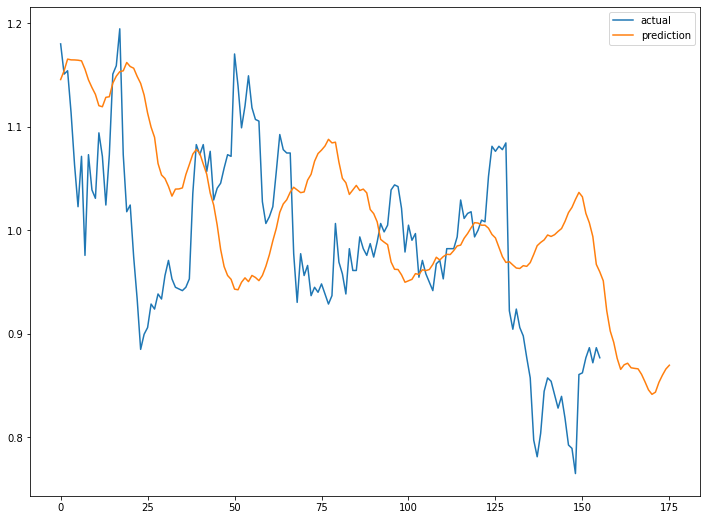

In [171]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [172]:
score = model.evaluate(X_test_t,y_test,batch_size=30)
print(score)

6/6 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0036
[0.001792924478650093, 0.003585848957300186]


In [173]:
test_sc_df[('Close',)].describe()

count    186.000000
mean       1.022579
std        0.115129
min        0.764610
25%        0.944805
50%        1.008929
75%        1.082386
max        1.295455
Name: (Close,), dtype: float64

In [174]:
pd.DataFrame(pred).describe()

,0
count,176.000000
mean,1.011339
std,0.079331
min,0.841236
25%,0.963297
50%,1.002142
75%,1.053883
max,1.165483


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

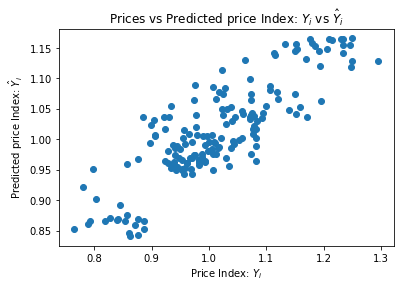

In [175]:
# 직선에 가까울 수록 정확도가 높다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")